## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [2]:
print(torch.__version__)

1.6.0


### Setting seed and checking GPU

In [3]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

cuda:0


# Pre-Training

## Splitting Dataset

In [ ]:
df = pd.read_csv("./new.csv")

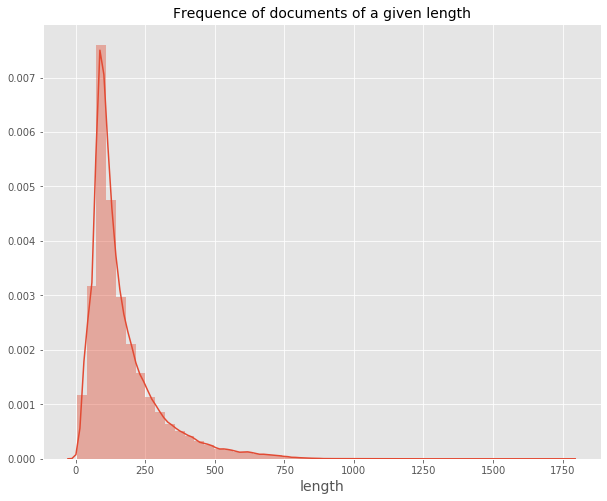

In [3]:
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['review'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [7]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
PRE_TRAINING_TRAIN_BATCH_SIZE = 32
PRE_TRAINING_VAL_BATCH_SIZE = 64
PRE_TRAINING_TEST_BATCH_SIZE = 64
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
PRE_TRAINING_DATASET_PATH = "./new.csv"

# Define columns to read.
review_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

fields = {'review' : ('review', review_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train, valid, test = TabularDataset(path=PRE_TRAINING_DATASET_PATH, 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.80, 0.1, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')

training_set_iter = Iterator(valid, batch_size=PRE_TRAINING_TRAIN_BATCH_SIZE, device=device, train=True, shuffle=True, sort=True)
valid_set_iter = Iterator(valid, batch_size=PRE_TRAINING_VAL_BATCH_SIZE, device=device, train=False, shuffle=False, sort=True)
# Test iterator, no shuffling or sorting required.
test_set_iter = Iterator(test, batch_size=PRE_TRAINING_TEST_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [8]:
def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Model Architecture

In [5]:
# Model with extra layers on top of RoBERTa
class ROBERTA(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTA, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 256)
        self.bn1 = torch.nn.LayerNorm(256)
        self.l2 = torch.nn.Linear(256, 64)
        self.bn2 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l3 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l3(x)
        
        return x

In [ ]:
def pretrain(model, optimizer, training_set_iter, valid_set_iter, scheduler, num_epochs):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
      
    global_step = 0  
    criterion = torch.nn.CrossEntropyLoss()
    
    # Train loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0 
        for (review, label), _ in train_iter:
            mask = (review != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source, attention_mask=mask)
            
            loss = criterion(y_pred, label)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                
                model.eval()
                
                with torch.no_grad():                    
                    for (review, target), _ in valid_iter:
                        mask = (review != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=review, attention_mask=mask)
                        
                        loss = criterion(y_pred, label)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / len(training_set_iter)
                valid_loss = valid_loss / len(valid_set_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], Pre-Training Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, train_loss, valid_loss))
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
     
    # Saving Pre-Trained Model as .pth file
    torch.save({'model_state_dict': model.state_dict()}, "./preTrained_model.pth")
        
    print('Pre-training done!')

In [ ]:
# Main training loop
PRE_TRAINING_NUM_EPOCHS = 12
steps_per_epoch = len(train_iter)

PRE_TRAINING_model = ROBERTA(0.4)
PRE_TRAINING_model = PRE_TRAINING_model.to(device)


PRE_TRAINING_optimizer = AdamW(PRE_TRAINING_model.parameters(), lr=1e-4)
PRE_TRAINING_scheduler = get_linear_schedule_with_warmup(PRE_TRAINING_optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*PRE_TRAINING_NUM_EPOCHS)

pretrain(model=PRE_TRAINING_model, training_set_iter=training_set_iter, valid_set_iter=valid_set_iter, optimizer=PRE_TRAINING_optimizer, scheduler=PRE_TRAINING_scheduler, num_epochs=PRE_TRAINING_NUM_EPOCHS)


# Classifier

## Splitting Dataset

In [10]:
# Set tokenizer hyperparameters.
CLASSIFIER_MAX_SEQ_LEN = 256
CLASSIFIER_TRAIN_BATCH_SIZE = 32
CLASSIFIER_VAL_BATCH_SIZE = 64
CLASSIFIER_TEST_BATCH_SIZE = 64
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
CLASSIFIER_DATASET_PATH = "../dataset/classify/final_prepro1.csv"

# Define columns to read.
review_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=CLASSIFIER_MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

label_field = Field(sequential=False, use_vocab=False, batch_first=True)

fields = {'review' : ('review', review_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train, valid, test = TabularDataset(path=CLASSIFIER_DATASET_PATH, 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.1, 0.2], 
                                                                            stratified=True, 
                                                                            strata_field='label')

training_set_iter = Iterator(valid, batch_size=CLASSIFIER_TRAIN_BATCH_SIZE, device=device, train=True, shuffle=True,sort_key=lambda x: len(x.review), sort=True, sort_within_batch=False)
valid_set_iter = Iterator(valid, batch_size=CLASSIFIER_VAL_BATCH_SIZE, device=device, train=False,  shuffle=True,sort_key=lambda x: len(x.review), sort=True, sort_within_batch=False)
# Test iterator, no shuffling or sorting required.
test_set_iter = Iterator(test, batch_size=CLASSIFIER_TEST_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [11]:
len(test_set_iter)

16

In [12]:
len(train)

6729

## Model Architecture

In [13]:
# Model with extra layers on top of RoBERTa
class Classifier(torch.nn.Module):
    def __init__(self, input_ch = 768, dropout_rate=0.3):
        super(Classifier, self).__init__()
        
#         self.l1 = torch.nn.Linear(input_ch, 256)
#         self.bn1 = torch.nn.LayerNorm(256)
        self.l2 = torch.nn.Linear(256, 64)
        self.bn2 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l3 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids):
#         x = self.l1(input_ids)
#         x = self.bn1(x)
        x = self.l2(input_ids)
        x = self.bn2(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l3(x)
        return x

In [15]:
def classifier(model, optimizer, training_set_iter, valid_set_iter, scheduler, num_epochs, preTrain_path):
    
    
#     preTrained_unet = torch.jit.load(preTrain_path)
#     model.load_state_dict(preTrained_unet, strict = False)
#     Initialize losses and loss histories
    state_dict = torch.load('../preTrained_model.pth')
    model.load_state_dict(state_dict['model_state_dict'], strict=False)
    global_step = 0  
    criterion = torch.nn.CrossEntropyLoss()
    
    # Train loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0 
        for (review, label), _ in training_set_iter:
            y_pred = model(input_ids=review.float())
            
            loss = criterion(y_pred, label)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % len(training_set_iter) == 0:
                
                model.eval()
                
                with torch.no_grad():                    
                    for (review, label), _ in valid_set_iter:
                        
                        y_pred = model(input_ids=review.float())
                        
                        loss = criterion(y_pred, label)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / len(training_set_iter)
                valid_loss = valid_loss / len(valid_set_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], Pre-Training Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, train_loss, valid_loss))
     
    # Saving Pre-Trained Model as .pth file
    torch.save({'model_state_dict': model.state_dict()}, "./final_model2.pth")
        
    print('Classification done!')

In [76]:
len(training_set_iter)

61

In [16]:
# Main training loop
CLASSIFIER_NUM_EPOCHS = 12
steps_per_epoch = len(training_set_iter)

CLASSIFIER_model = ROBERTA()
CLASSIFIER_model = CLASSIFIER_model.to(device)


CLASSIFIER_optimizer = AdamW(CLASSIFIER_model.parameters(), lr=1e-4)
CLASSIFIER_scheduler = get_linear_schedule_with_warmup(CLASSIFIER_optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*CLASSIFIER_NUM_EPOCHS)

classifier(model=CLASSIFIER_model,optimizer=CLASSIFIER_optimizer, training_set_iter=training_set_iter, valid_set_iter=valid_set_iter,  scheduler=CLASSIFIER_scheduler, num_epochs=CLASSIFIER_NUM_EPOCHS, preTrain_path='./final_model.pth')


RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 2.00 GiB total capacity; 1.12 GiB already allocated; 110.88 MiB free; 1.20 GiB reserved in total by PyTorch)

In [7]:
model = ROBERTA()
model = model.to(device)
state_dict = torch.load('./final_model1.pth', map_location=device)
model.load_state_dict(state_dict['model_state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['roberta.embeddings.position_ids', 'roberta.embeddings.word_embeddings.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.0.intermediate.dense.bias', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.

Classification Report:
              precision    recall  f1-score   support

           1     0.5628    0.8851    0.6881       496
           0     0.6851    0.2667    0.3839       465

    accuracy                         0.5858       961
   macro avg     0.6240    0.5759    0.5360       961
weighted avg     0.6220    0.5858    0.5409       961



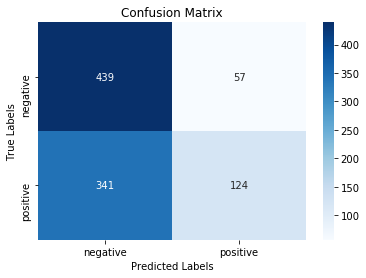

In [10]:
evaluate(model, test_set_iter)

In [8]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['negative', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'positive'])

In [6]:
model = ROBERTA()
model = model.to(device)
state_dict = torch.load('../preTrained_model.pth')
model.load_state_dict(state_dict['model_state_dict'], strict=False)

<All keys matched successfully>

In [9]:
evaluate(model, test_set_iter)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 2.00 GiB total capacity; 1.21 GiB already allocated; 14.88 MiB free; 1.30 GiB reserved in total by PyTorch)

In [84]:
state_dict = torch.load('../preTrained_model.pth')

In [86]:
evaluate(state_dict['model_state_dict'], test_set_iter)

TypeError: 'collections.OrderedDict' object is not callable